# Implement bout detection + shuffling + pseudonym rotation + timestamp perturbation

In [1]:
import numpy as np
import torch
import os, sys
from pathlib import Path

project_root = os.path.abspath("..")
src_root = os.path.join(project_root, "src")

sys.path = [p for p in sys.path if p not in (project_root, src_root)]

sys.path.insert(0, project_root)
sys.path.insert(1, src_root)


if "src" in sys.modules:
    del sys.modules["src"]

import src

In [19]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.metrics import roc_auc_score


In [20]:
# RAW TRAIN
X_train_raw = np.loadtxt("../data/UCI_HAR_Dataset/train/X_train.txt")
y_train_raw = np.loadtxt("../data/UCI_HAR_Dataset/train/y_train.txt", dtype=int)
user_train_raw = np.loadtxt("../data/UCI_HAR_Dataset/train/subject_train.txt", dtype=int)

# RAW TEST
X_test_raw = np.loadtxt("../data/UCI_HAR_Dataset/test/X_test.txt")
y_test_raw = np.loadtxt("../data/UCI_HAR_Dataset/test/y_test.txt", dtype=int)
user_test_raw = np.loadtxt("../data/UCI_HAR_Dataset/test/subject_test.txt", dtype=int)

# CONCAT, NO SHUFFLE
X_raw = np.concatenate([X_train_raw, X_test_raw], axis=0)
y_raw = np.concatenate([y_train_raw, y_test_raw], axis=0)
user_ids_raw = np.concatenate([user_train_raw, user_test_raw], axis=0)

# SIMPLE TIMESTAMP: index within each user sequence
timestamps_raw = np.zeros_like(user_ids_raw)
ptr = {}
for i, u in enumerate(user_ids_raw):
    if u not in ptr:
        ptr[u] = 0
    timestamps_raw[i] = ptr[u]
    ptr[u] += 1

print("N windows:", len(y_raw))
print("Users:", np.unique(user_ids_raw).shape[0])
print(pd.Series(user_ids_raw).value_counts().describe())


N windows: 10299
Users: 30
count     30.000000
mean     343.300000
std       35.709701
min      281.000000
25%      317.750000
50%      342.500000
75%      371.000000
max      409.000000
Name: count, dtype: float64


In [ ]:
def make_bouts(user_ids, timestamps, y, bout_len=50):
    """
    Group each user's time series into bouts of fixed length.
    Returns:
        bout_ids: (N,) int, bout index for each window
    """
    bout_ids = np.zeros_like(user_ids, dtype=int)
    bout_ctr = 0

    # sort by (user, time)
    order = np.lexsort((timestamps, user_ids))
    user_ids = user_ids[order]
    timestamps = timestamps[order]
    y = y[order]

    for u in np.unique(user_ids):
        idxs = np.where(user_ids == u)[0]
        for i in range(0, len(idxs), bout_len):
            chunk = idxs[i:i + bout_len]
            bout_ids[chunk] = bout_ctr
            bout_ctr += 1

    # revert to original order
    bout_ids_unsort = np.zeros_like(bout_ids)
    bout_ids_unsort[order] = bout_ids
    return bout_ids_unsort


def build_meta_view(user_ids, timestamps, y, bout_ids,
                    shuffle=False, rotate_pseudo=False,
                    bin_size=60.0, jitter_std=15.0, seed=0):
    """
    Build a metadata dataframe describing what the SERVER sees:
    columns: orig_idx, user (true), pseudo, bout, t, label
    """
    rng = np.random.default_rng(seed)
    N = len(y)
    orig_idx = np.arange(N)

    # Shuffle within each bout if requested
    if shuffle:
        perm = np.arange(N)
        for b in np.unique(bout_ids):
            idxs = np.where(bout_ids == b)[0]
            rng.shuffle(idxs)
            perm[idxs] = idxs
        orig_idx = orig_idx[perm]
        user_ids = user_ids[perm]
        timestamps = timestamps[perm]
        bout_ids = bout_ids[perm]
        y = y[perm]

    # Pseudonym mapping
    if rotate_pseudo:
        pseudo = np.zeros_like(user_ids)
        for i, b in enumerate(np.unique(bout_ids)):
            pseudo[bout_ids == b] = i + 1
    else:
        pseudo = user_ids.copy()

    # Timestamp perturbation: snap to bins + Gaussian jitter
    t = timestamps.astype(float)
    # binning
    t = (t / bin_size).astype(int) * bin_size
    if jitter_std > 0:
        t = t + rng.normal(loc=0.0, scale=jitter_std, size=N)

    meta = pd.DataFrame({
        "orig_idx": orig_idx,
        "user": user_ids,
        "pseudo": pseudo,
        "bout": bout_ids,
        "t": t,
        "label": y,
    })
    return meta


meta_raw head:


,orig_idx,user,pseudo,bout,t,label
0,0,1,1,0,0.0,5
1,1,1,1,0,0.0,5
2,2,1,1,0,0.0,5
3,3,1,1,0,0.0,5
4,4,1,1,0,0.0,5


meta_def head:


,orig_idx,user,pseudo,bout,t,label
0,0,1,1,0,5.946336,5
1,1,1,1,0,18.733779,5
2,2,1,1,0,4.248783,5
3,3,1,1,0,27.644454,5
4,4,1,1,0,19.175978,5


Bout length stats:
count    222.000000
mean      46.391892
std       10.319973
min        2.000000
25%       50.000000
50%       50.000000
75%       50.000000
max       50.000000
dtype: float64


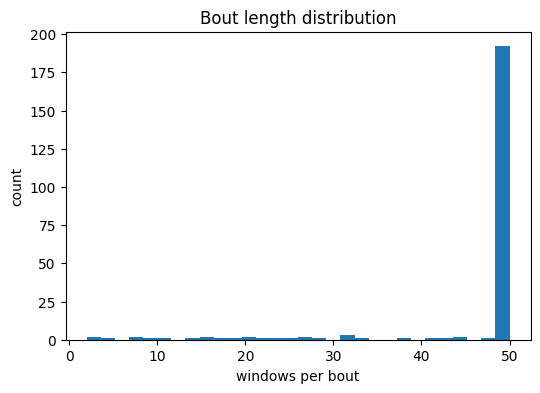

In [ ]:
# 1) Build bouts
bout_ids = make_bouts(user_ids_raw, timestamps_raw, y_raw, bout_len=50)

# 2) RAW view: no defenses
meta_raw = build_meta_view(
    user_ids_raw, timestamps_raw, y_raw, bout_ids,
    shuffle=False, rotate_pseudo=False, 
    bin_size=60.0, jitter_std=0.0,
    seed=0
)

# 3) DEFENDED view: full unlinkability
meta_def = build_meta_view(
    user_ids_raw, timestamps_raw, y_raw, bout_ids,
    shuffle=True, rotate_pseudo=True, 
    bin_size=60.0, jitter_std=15.0,
    seed=0
)

print("meta_raw head:")
display(meta_raw.head())
print("meta_def head:")
display(meta_def.head())

# Inspect bout sizes in RAW view
bout_sizes = meta_raw.groupby("bout").size()
print("Bout length stats:")
print(bout_sizes.describe())

plt.figure(figsize=(6,4))
plt.hist(bout_sizes, bins=30)
plt.xlabel("windows per bout")
plt.ylabel("count")
plt.title("Bout length distribution")
plt.show()


In [ ]:
def linkage_attack(meta_df, use_pseudo=True, max_pos_pairs_per_user=50, seed=0):
    rng = np.random.default_rng(seed)

    # 1. Per-bout feature: label histogram
    K = int(meta_df["label"].max()) + 1
    bouts = []

    for b, g in meta_df.groupby("bout"):
        labs = g["label"].to_numpy()
        hist = np.bincount(labs, minlength=K).astype(float)
        s = hist.sum()
        if s > 0:
            hist /= s
        user = int(g["user"].iloc[0])
        pseudo = int(g["pseudo"].iloc[0])
        bouts.append((user, pseudo, hist))

    if len(bouts) < 2:
        raise RuntimeError("Not enough bouts")

    by_user = {}
    for idx, (u, p, h) in enumerate(bouts):
        by_user.setdefault(u, []).append(idx)

    scores = []
    labels_bin = []

    # Positive pairs: same true user
    for u, idxs in by_user.items():
        if len(idxs) < 2:
            continue
        n_pairs = 0
        for i in range(len(idxs)):
            for j in range(i+1, len(idxs)):
                if n_pairs >= max_pos_pairs_per_user:
                    break
                ui, pi, hi = bouts[idxs[i]]
                uj, pj, hj = bouts[idxs[j]]
                base = float(np.dot(hi, hj))
                if use_pseudo and pi == pj:
                    base += 1.0
                scores.append(base)
                labels_bin.append(1)
                n_pairs += 1

    n_pos = sum(labels_bin)
    if n_pos == 0:
        raise RuntimeError("No positive pairs")

    # Negative pairs: different users
    all_idxs = np.arange(len(bouts))
    n_neg = 0
    while n_neg < n_pos:
        i, j = rng.choice(all_idxs, size=2, replace=False)
        ui, pi, hi = bouts[i]
        uj, pj, hj = bouts[j]
        if ui == uj:
            continue
        base = float(np.dot(hi, hj))
        if use_pseudo and pi == pj:
            base += 1.0
        scores.append(base)
        labels_bin.append(0)
        n_neg += 1

    scores = np.array(scores)
    labels_bin = np.array(labels_bin)

    auc = roc_auc_score(labels_bin, scores)
    return auc, scores, labels_bin


In [24]:
print("=== Strong linkage attack on RAW vs DEFENDED ===")

# RAW: server sees stable pseudonyms (user IDs)
auc_raw, _, _ = linkage_attack(meta_raw, use_pseudo=True, seed=0)
print(f"RAW (no defenses) AUC       : {auc_raw:.3f}")

# DEFENDED: server sees per-bout pseudonyms + shuffle + jitter
auc_def, _, _ = linkage_attack(meta_def, use_pseudo=True, seed=0)
print(f"DEFENDED (full unlinkability) AUC: {auc_def:.3f}")


=== Strong linkage attack on RAW vs DEFENDED ===
RAW (no defenses) AUC       : 1.000
DEFENDED (full unlinkability) AUC: 0.443


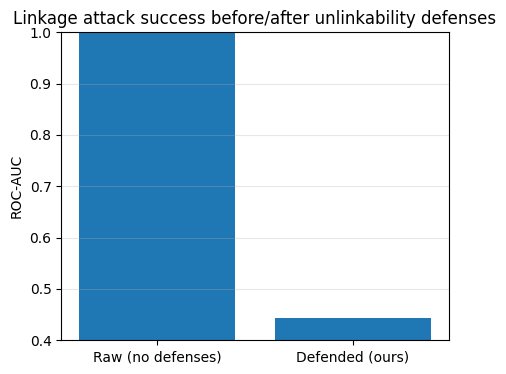

In [25]:
labels = ["Raw (no defenses)", "Defended (ours)"]
aucs = [auc_raw, auc_def]

plt.figure(figsize=(5,4))
plt.bar(labels, aucs)
plt.ylim(0.4, 1.0)
plt.ylabel("ROC-AUC")
plt.title("Linkage attack success before/after unlinkability defenses")
plt.grid(axis="y", alpha=0.3)
plt.show()
